In [1]:
!pip install lightgbm xgboost


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb

In [9]:
# Load dataset
train = pd.read_csv("Documents/Python/Titanic_train.csv")
test = pd.read_csv("Documents/Python/Titanic_test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [13]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
# Combine train and test for consistent preprocessing
test['Survived'] = np.nan
combined = pd.concat([train, test], sort=False)
combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
# EDA - Checking for missing values
print("\nMissing values:\n", combined.isnull().sum())


Missing values:
 PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


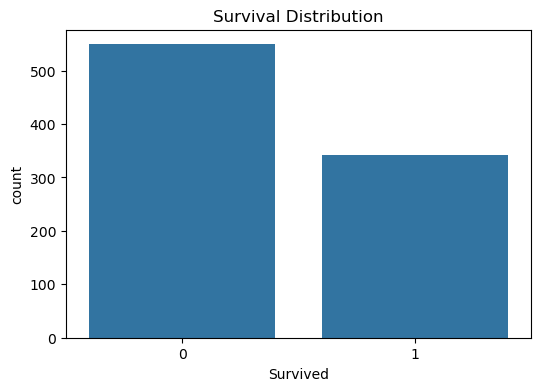

In [19]:
# EDA - Visualizations
plt.figure(figsize=(6,4))
sns.countplot(x='Survived', data=train)
plt.title("Survival Distribution")
plt.show()

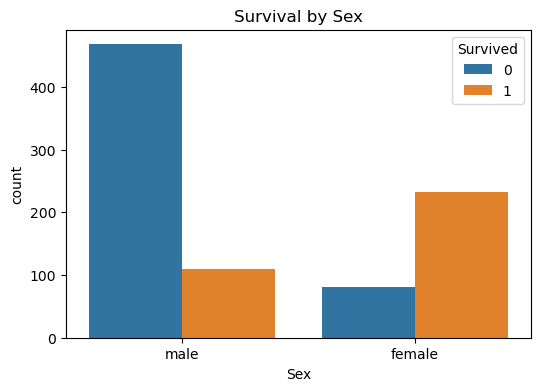

In [21]:
plt.figure(figsize=(6,4))
sns.countplot(x='Sex', hue='Survived', data=train)
plt.title("Survival by Sex")
plt.show()

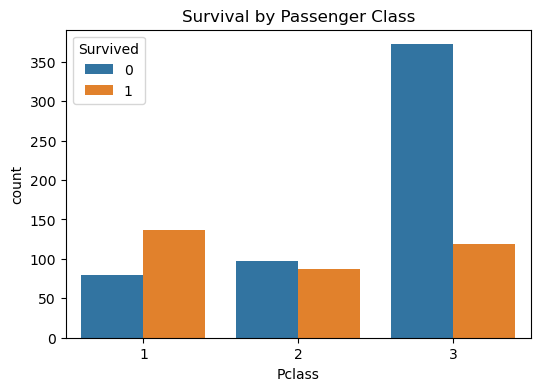

In [23]:
plt.figure(figsize=(6,4))
sns.countplot(x='Pclass', hue='Survived', data=train)
plt.title("Survival by Passenger Class")
plt.show()

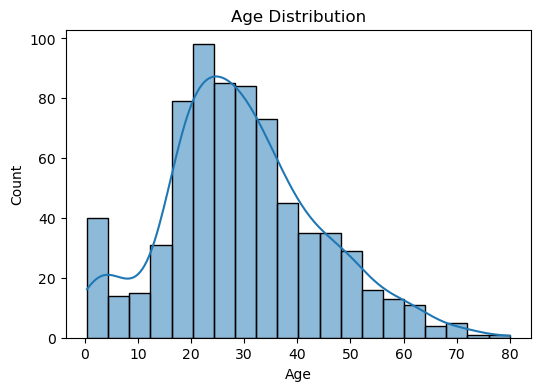

In [25]:
plt.figure(figsize=(6,4))
sns.histplot(train['Age'].dropna(), kde=True)
plt.title("Age Distribution")
plt.show()


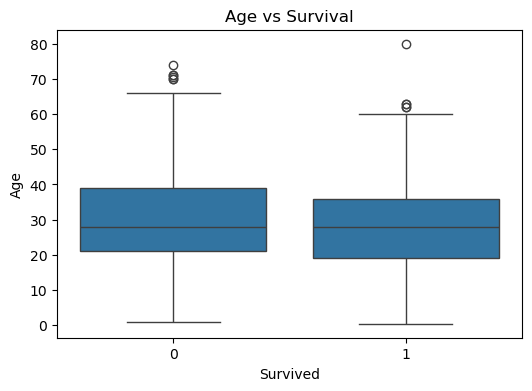

In [27]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Survived', y='Age', data=train)
plt.title("Age vs Survival")
plt.show()

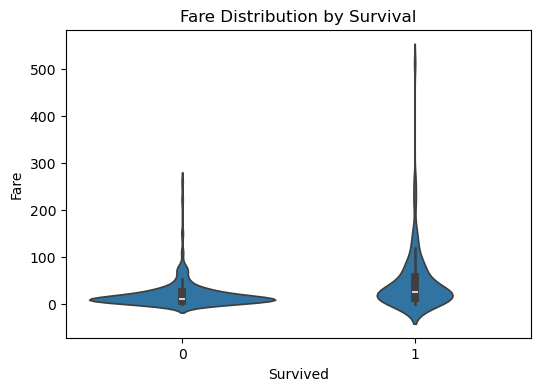

In [29]:
plt.figure(figsize=(6,4))
sns.violinplot(x='Survived', y='Fare', data=train)
plt.title("Fare Distribution by Survival")
plt.show()

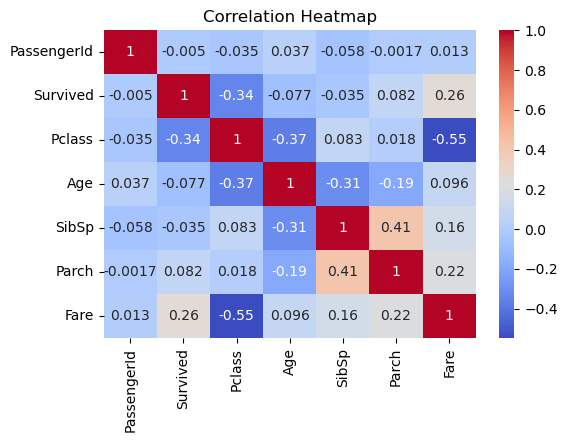

In [31]:
plt.figure(figsize=(6,4))
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [33]:
# Fill missing Age and Fare with median
combined['Age'].fillna(combined['Age'].median(), inplace=True)
combined['Fare'].fillna(combined['Fare'].median(), inplace=True)

C:\Users\Integrated\AppData\Local\Temp\ipykernel_17224\656565624.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined['Age'].fillna(combined['Age'].median(), inplace=True)
C:\Users\Integrated\AppData\Local\Temp\ipykernel_17224\656565624.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [35]:
# Fill Embarked with mode
combined['Embarked'].fillna(combined['Embarked'].mode()[0], inplace=True)

C:\Users\Integrated\AppData\Local\Temp\ipykernel_17224\270744445.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined['Embarked'].fillna(combined['Embarked'].mode()[0], inplace=True)


In [37]:
# Drop Cabin due to many missing values
combined.drop('Cabin', axis=1, inplace=True)

In [39]:
# Encode Sex and Embarked
le = LabelEncoder()
combined['Sex'] = le.fit_transform(combined['Sex'])
combined['Embarked'] = le.fit_transform(combined['Embarked'])

In [41]:
# Drop non-informative features
combined.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [43]:
# Separate back train and test
train_cleaned = combined[combined['Survived'].notna()]
test_cleaned = combined[combined['Survived'].isna()].drop('Survived', axis=1)
y = train_cleaned['Survived'].astype(int)
X = train_cleaned.drop('Survived', axis=1)

In [45]:
# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# Define and train LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_val)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [49]:
# Define and train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)

C:\Users\Integrated\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:35:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [57]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    print(f"\nEvaluation for {model_name}:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


Evaluation for LightGBM:
Accuracy: 0.8212290502793296
Precision: 0.7837837837837838
Recall: 0.7837837837837838
F1 Score: 0.7837837837837838

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       105
           1       0.78      0.78      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.82      0.82      0.82       179



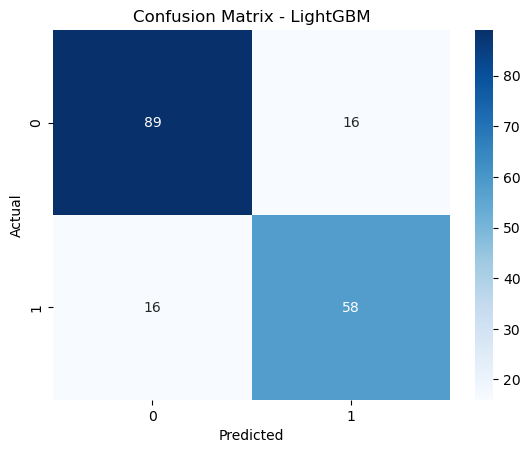


Evaluation for XGBoost:
Accuracy: 0.7988826815642458
Precision: 0.7567567567567568
Recall: 0.7567567567567568
F1 Score: 0.7567567567567568

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83       105
           1       0.76      0.76      0.76        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



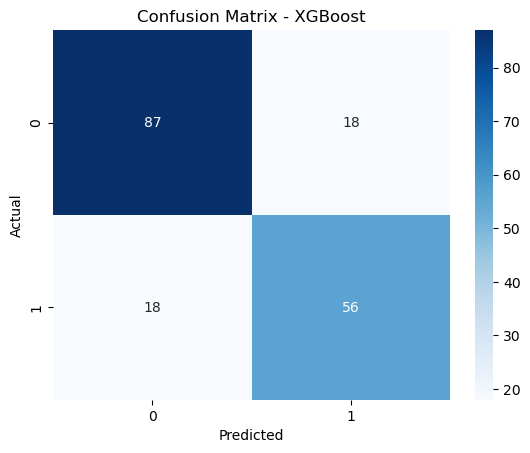

In [59]:
# Evaluate both models
evaluate_model(y_val, y_pred_lgb, "LightGBM")
evaluate_model(y_val, y_pred_xgb, "XGBoost")

In [61]:
# Cross-validation
print("\nCross-validation scores:")
lgb_cv = cross_val_score(lgb_model, X, y, cv=5, scoring='accuracy')
xgb_cv = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
print("LightGBM CV Accuracy:", lgb_cv.mean())
print("XGBoost CV Accuracy:", xgb_cv.mean())


Cross-validation scores:
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

C:\Users\Integrated\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:39:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Integrated\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:39:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Integrated\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:39:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Integrated\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:39:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not use

LightGBM CV Accuracy: 0.8260686711443098
XGBoost CV Accuracy: 0.8182097796748478


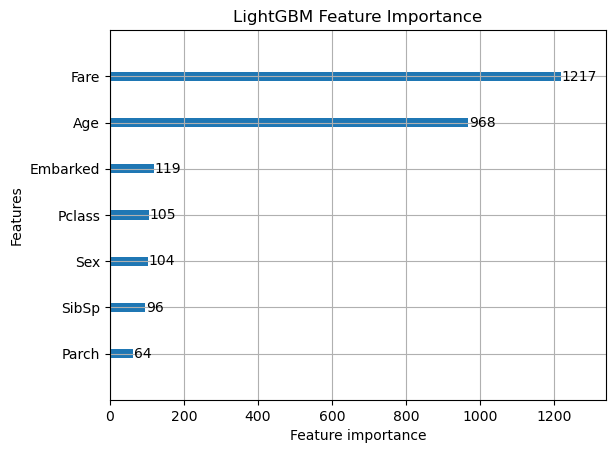

In [63]:
# Feature Importance - LightGBM
lgb.plot_importance(lgb_model)
plt.title("LightGBM Feature Importance")
plt.show()

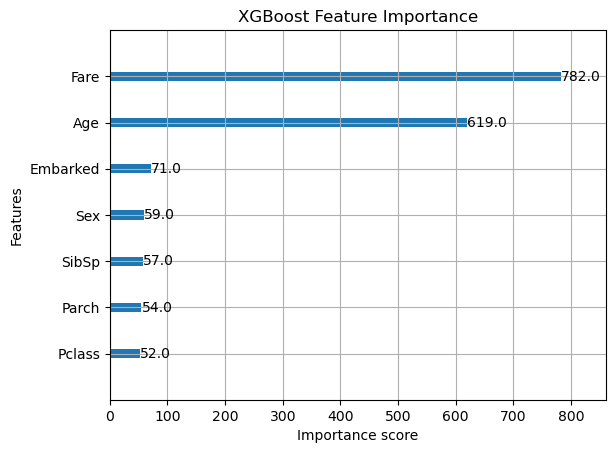

In [65]:
# Feature Importance - XGBoost
xgb.plot_importance(xgb_model)
plt.title("XGBoost Feature Importance")
plt.show()

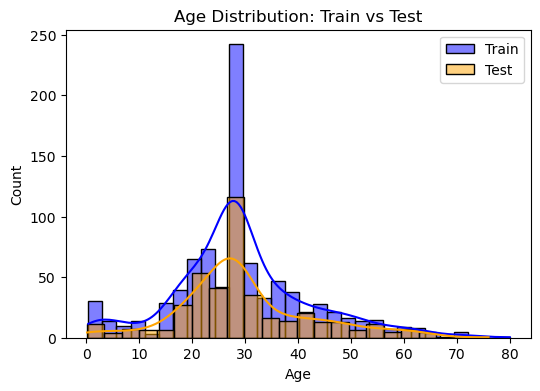

In [67]:
# Compare Age distribution
plt.figure(figsize=(6,4))
sns.histplot(train_cleaned['Age'], kde=True, label='Train', color='blue')
sns.histplot(test_cleaned['Age'], kde=True, label='Test', color='orange')
plt.legend()
plt.title("Age Distribution: Train vs Test")
plt.show()
